# Code Red: The Business Impact of Code Quality

This notebook contains the complete replication package, including raw data and scripts for the statistical analysis, for the paper "Code Red: The Business Impact of Code Quality: A Quantitative Study of 39 Proprietary Production Codebases" by Adam Tornhill & Markus Borg, 2022.

In [1]:
!conda install -y pandas

Solving environment: done

## Package Plan ##

  environment location: /Users/adam/opt/miniconda3/envs/ml

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.10.8          |   py39hecd8cb5_2         152 KB
    openssl-1.1.1m             |       hca72f7f_0         2.2 MB
    pandas-1.3.5               |   py39h743cdd8_0         9.2 MB
    ------------------------------------------------------------
                                           Total:        11.6 MB

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2021.10.~ --> pkgs/main::ca-certificates-2021.10.26-hecd8cb5_2
  certifi            conda-forge::certifi-2021.10.8-py39h6~ --> pkgs/main::certifi-2021.10.8-py39hecd8cb5_2
  openssl            conda-forge::openssl-1.1.1l-h0d85af4_0 --> pkgs/main::openssl-1.1.1m-hca72f7f_0
  pandas            

## Data collection and preparation

Read the CSV, and make sure we add the code health category which we use as the independent variable in the calculations:

In [26]:
import pandas as pd

def _by_code_health_category(df):
    def v_to_category(v):
        if v < 4.0:
            return 'alert'
        if v < 9.0:
            return 'warning'
        return 'healthy'

    code_health_categories = [v_to_category(v) for v in df['code_health_now']]
    df['code_health_category'] = code_health_categories

def read_cleaned_data_from(file_name):
    df = pd.read_csv(file_name, sep=';', decimal=",")
    
    _by_code_health_category(df)
    
    return _keep_entities_with_issues(df)

In [14]:
df = read_cleaned_data_from('./data/code_health_ct_data.csv')

In [15]:
df.describe()

,index,issues,mean_time_for_issue,lines_of_code,code_health_now,total,max_time_for_issue,total_defects
count,30737.000000,30737.000000,2.538600e+04,25386.000000,30737.000000,3.073700e+04,3.073700e+04,30737.000000
mean,2083.158831,4.170023,8.573125e+03,122.128338,9.577271,3.225713e+04,1.828689e+04,0.353743
std,2024.517390,7.126601,2.539253e+04,520.709154,1.104758,1.000183e+05,4.849241e+04,1.433712
min,0.000000,1.000000,6.000000e+01,0.000000,1.000000,6.000000e+01,6.000000e+01,0.000000
25%,441.000000,1.000000,1.560000e+03,11.000000,9.750000,2.940000e+03,2.280000e+03,0.000000
50%,1397.000000,2.000000,3.360000e+03,49.000000,10.000000,9.060000e+03,6.180000e+03,0.000000
75%,3251.000000,4.000000,8.014500e+03,127.000000,10.000000,2.700000e+04,1.626000e+04,0.000000
max,8395.000000,293.000000,1.452780e+06,72630.000000,10.000000,5.985900e+06,1.452780e+06,58.000000


To meet the pre-conditions for an ANOVA, we must ensure normality of the dependent variables. We normalize DV-RQ2 and DV-RQ3 using the Yeo-Johnson algorithm. The scaled values are used for plots and descriptive statistics.

In [22]:
from scipy import stats
import math
# Yeo-Johnson transform
from sklearn.preprocessing import PowerTransformer
import numpy as np

def _scale(df, column_to_scale):
    max_v = df[column_to_scale].max()
    
    def v_to_scaled(v):
        return v / max(max_v, 1)
    
    scaled = [v_to_scaled(v) for v in df[column_to_scale]]
    df[column_to_scale + '_scaled'] = scaled
    return df

def _normalize_yj_transform(df, column_to_normalize):
    pt = PowerTransformer(method='yeo-johnson')
    
    data = np.array(df[column_to_normalize])
    reshaped_data = np.array(data).reshape(-1, 1)
    
    pt.fit(reshaped_data)
    df[column_to_normalize + '_norm'] = pt.transform(reshaped_data)
    return df
    
def normalize_combined_df(df):
    _scale(df, 'total_defects')
    
    
    # graphs with denormalized cycle times are much easier to interpret.
    # however, we need to have the data follow a normal distribution to make significance tests with an ANOVA:

    _normalize_yj_transform(df, 'max_time_for_issue')
    _scale(df, 'max_time_for_issue')
    _scale(df, 'max_time_for_issue_norm')
    
    _scale(df, 'mean_time_for_issue')
    _normalize_yj_transform(df, 'mean_time_for_issue')
    _normalize_yj_transform(df, 'mean_time_for_issue_scaled')
    
    return df


In [23]:
df = normalize_combined_df(df)

In [24]:
df.describe()

,index,issues,mean_time_for_issue,lines_of_code,code_health_now,total,max_time_for_issue,total_defects,total_defects_scaled,max_time_for_issue_norm,max_time_for_issue_scaled,max_time_for_issue_norm_scaled,mean_time_for_issue_scaled,mean_time_for_issue_norm,mean_time_for_issue_scaled_norm
count,30737.000000,30737.000000,2.538600e+04,25386.000000,30737.000000,3.073700e+04,3.073700e+04,30737.000000,30737.000000,3.073700e+04,30737.000000,3.073700e+04,25386.000000,2.538600e+04,2.538600e+04
mean,2083.158831,4.170023,8.573125e+03,122.128338,9.577271,3.225713e+04,1.828689e+04,0.353743,0.006099,3.323409e-16,0.012588,6.291938e-17,0.005901,-5.173081e-16,2.369578e-16
std,2024.517390,7.126601,2.539253e+04,520.709154,1.104758,1.000183e+05,4.849241e+04,1.433712,0.024719,1.000016e+00,0.033379,2.466993e-01,0.017479,1.000020e+00,1.000020e+00
min,0.000000,1.000000,6.000000e+01,0.000000,1.000000,6.000000e+01,6.000000e+01,0.000000,0.000000,-2.693156e+00,0.000041,-6.643890e-01,0.000041,-2.821856e+00,-1.264292e+00
25%,441.000000,1.000000,1.560000e+03,11.000000,9.750000,2.940000e+03,2.280000e+03,0.000000,0.000000,-6.281784e-01,0.001569,-1.549687e-01,0.001074,-6.001037e-01,-7.927589e-01
50%,1397.000000,2.000000,3.360000e+03,49.000000,10.000000,9.060000e+03,6.180000e+03,0.000000,0.000000,4.934223e-03,0.004254,1.217250e-03,0.002313,-3.509032e-02,-3.079324e-01
75%,3251.000000,4.000000,8.014500e+03,127.000000,10.000000,2.700000e+04,1.626000e+04,0.000000,0.000000,6.483869e-01,0.011192,1.599540e-01,0.005517,6.246014e-01,6.248456e-01
max,8395.000000,293.000000,1.452780e+06,72630.000000,10.000000,5.985900e+06,1.452780e+06,58.000000,1.000000,4.053583e+00,1.000000,1.000000e+00,1.000000,5.038840e+00,2.348651e+00


In [25]:
### Visualize the normality of our dependent variables

/Users/adam/opt/miniconda3/envs/ml/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adam/opt/miniconda3/envs/ml/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Normalized Data (max time')

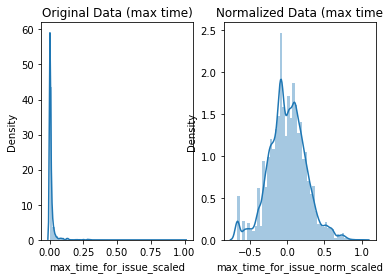

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax=plt.subplots(1,2)

sns.distplot(df['max_time_for_issue_scaled'], ax=ax[0])
ax[0].set_title('Original Data (max time)')

sns.distplot(df['max_time_for_issue_norm_scaled'], ax=ax[1])
ax[1].set_title('Normalized Data (max time')

/Users/adam/opt/miniconda3/envs/ml/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adam/opt/miniconda3/envs/ml/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Normalized Data (mean time)')

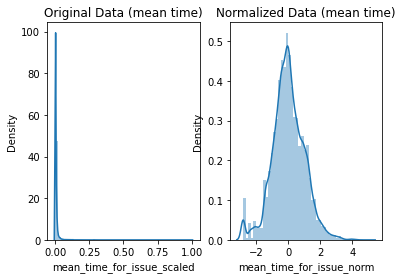

In [28]:
fig, ax=plt.subplots(1,2)

sns.distplot(df['mean_time_for_issue_scaled'], ax=ax[0])
ax[0].set_title('Original Data (mean time)')

sns.distplot(df['mean_time_for_issue_norm'], ax=ax[1])
ax[1].set_title('Normalized Data (mean time)')

### Descriptive graphs

Visualize the programming language statistics:

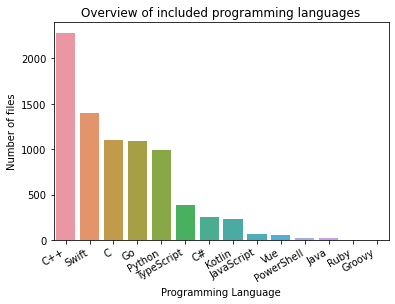

In [31]:
ax_lang = sns.countplot(data=df, x='language', order=df['language'].value_counts().index)
ax_lang.set(xlabel='Programming Language', ylabel='Number of files', title='Overview of included programming languages')
plt.setp(ax_lang.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show(ax_lang)

## Statistical tests

Split the distribution into three groups, each one representing a code health category:

In [32]:
healthy = df[df['code_health_category']=='healthy']
warning = df[df['code_health_category']=='warning']
alert = df[df['code_health_category']=='alert']

### [RQ1] How does the number of reported defects in source code files correlate to source code quality?

We use the Anderson-Darling test (A-D test), which is a modification of Kolmogorov-Smirnov test. A-D tests whether a given sample of observations is drawn from a given probability distribution (in our case from normal distribution). The null hypothesis is that the samples are *not* from a normal distribution.

In [36]:
from scipy.stats import anderson

result = (anderson(df['total_defects_scaled'], dist='norm'))

print(f"A-D statistic: {result[0]}")
print(f"Critical values: {result[1]}")
print(f"Significance levels: {result[2]}")

A-D statistic: 7719.706302409184
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]


Since we don't have sampels from a normal distribution, we use a significance test for non-normal distribution using the Kruskal-Wallis Test:

In [39]:
from scipy import stats

#perform Kruskal-Wallis Test: it is considered to be the non-parametric equivalent of the One-Way ANOVA.
stats.kruskal(healthy['total_defects_scaled'], warning['total_defects_scaled'], alert['total_defects_scaled'])

KruskalResult(statistic=1645.0453054602567, pvalue=0.0)

In [41]:
# Multiple comparisons are done using DSCF

import scikit_posthocs as sp

sp.posthoc_dscf(df,val_col="total_defects_scaled",group_col="code_health_category")

,healthy,warning,alert
healthy,1.000,0.001,0.001
warning,0.001,1.000,0.001
alert,0.001,0.001,1.000


Add visual plots of the results to highlight the differences in means:

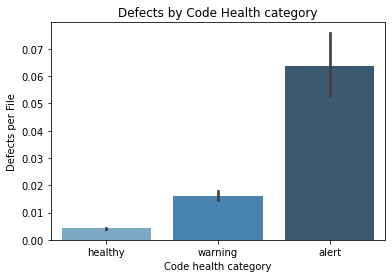

In [38]:
def show_total_defects_by_code_health_for(df):
    bx = sns.barplot(x="code_health_category", y="total_defects_scaled", data=df, order=['healthy', 'warning', 'alert'], palette="Blues_d")
    bx.set(xlabel='Code health category', ylabel='Defects per File', title='Defects by Code Health category')
    plt.show(bx)

show_total_defects_by_code_health_for(df)